###### The latest version of this IPython notebook is available at [http://github.com/jckantor](http://github.com/jckantor)  for noncommercial use under terms of the [Creative Commons Attribution Noncommericial ShareAlike License](http://creativecommons.org/licenses/by-nc-sa/4.0/).

Jeffrey C. Kantor (Kantor.1@nd.edu)

# Antoine's Equation and Database

The purpose of this notebook is to demonstrate the use Antoine's equation for routine chemical calcualtions. The notebook uses Google Sheets as a data repository of coefficients for Antoine parameters for a selected set of chemical species.

#### Table of Contents

* [Introduction to Antoine's Equation](#Introduction-to-Antoine's-Equation)
* [Calculating Saturation Pressure](#Calculating-Saturation-Pressure)
* [Plotting Saturation Pressure](#Plotting-Saturation-Pressure)
* [Calculating Saturation Temperature](#Calculating-Saturation-Temperature)
* [Specific Humidity](#Specific-Humidity)
* [Exercises](#Exercises)

#### How to Run this Notebook

You can open run this notebook directly by clicking on 

[![Binder](http://mybinder.org/badge.svg)](http://mybinder.org/repo/jckantor/Antoine-Database)

then selecting `Run All` under the Jupyter `Cell` menu. Alternatively, if you have access to a Jupyter development environment (such as [Anaconda](https://www.continuum.io/downloads)), you can download this notebook using `Download as ...` under the Jupyter `File` menu, or fork the entire project from the [github repository](https://github.com/jckantor/Antoine-Database).

## Introduction to Antoine's Equation

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('VuiTiNP7QsU') 

Antoine's equation is used to estimate the pressure of the vapor phase of a pure component in equilibrium its pure liquid phase as a function of temperature. The form of the equation is

$$\log_{10} P^{sat}(T) = A - \frac{B}{T+C}$$

where $A$, $B$, and $C$ are constants specific to the species of interest. A data set of coefficients been prepared as a [Google Sheet](https://docs.google.com/spreadsheets/d/1lqIWdnmjiZX2LwHZ_5TdPXDOEn8hp-ZkdONlbjA-P1k/edit?usp=sharing) and read in the notebook by running the following cell.

In [2]:
import requests
from StringIO import StringIO
import pandas as pd

r = requests.get('https://docs.google.com/spreadsheets/d/' \
                 + '1lqIWdnmjiZX2LwHZ_5TdPXDOEn8hp-ZkdONlbjA-P1k' \
                 + '/export?format=csv&id')

csv = pd.io.parsers.read_csv(StringIO(r.content))

idx = pd.MultiIndex.from_tuples(zip(csv['Species'].str.lower(),csv['Tmin'],csv['Tmax']),
                         names=['Species','Tmin','Tmax'])

adb = pd.DataFrame(index = idx)
for v in ['A','B','C']:
    adb[v] = pd.Series(list(csv[v]),index = idx)

adb

,,,A,B,C
Species,Tmin,Tmax,,,
acetaldehyde,-45.0,70,8.00550,1600.000,291.800
acetic acid,16.7,320,7.38782,1533.313,222.309
acetone,-94.3,235,7.02447,1161.000,224.000
benzene,8.0,103,6.90565,1211.033,220.790
ethanol,-2.0,100,8.04494,1554.300,222.650
isopentane,-50.0,58,6.78967,1020.012,233.097
n-heptane,-2.0,124,6.89677,1264.900,216.540
n-hexane,-25.0,92,6.87601,1171.170,224.410
methanol,-14.0,65,7.89750,1474.080,229.130


## Calculating Saturation Pressure

Calculating the saturation pressure is a matter of implementing a function to evaluate Antoine's equation for a specified species at a specified temperature. The following function  accepts a `numpy` array of temperatures which it evaluates recursively. The function scans through temperature ranges available for the given species, returning `nan` if the specified temperature is out of range of every available temperature range.

In [3]:
import numpy as np

def Psat(species,T):
    if isinstance(T,np.ndarray):
        return [Psat(species,t) for t in T]
    for Tmin,Tmax in adb.ix[species.lower()].index:
        if (T >= Tmin) & (T <= Tmax):
            A = adb.ix[species.lower(),Tmin,Tmax]['A']
            B = adb.ix[species.lower(),Tmin,Tmax]['B']
            C = adb.ix[species.lower(),Tmin,Tmax]['C']
            return 10.0**(A - B/(T + C) )
    else:
        return float('nan')

#### Example Problem
_What is the saturation pressure of water at 100 deg. C?_

In [4]:
species = 'water'
T = 100.0

print 'Saturation pressure of', species, 
print 'at', T, 'deg C =', 
print Psat(species,T), 'mmHg'

Saturation pressure of water at 100.0 deg C = 759.983043308 mmHg


#### Example Problem
_What is the highest altitude a human can travel before blood boils at normal body temperature (37 deg. C)?_

This is known as the [Armstrong Limit](https://en.wikipedia.org/wiki/Armstrong_limit). The saturation pressure of water at 37 deg. C is computed as follows.

In [5]:
species = 'water'
T = 37.0
print 'Saturation pressure of', species, 
print 'at', T, 'deg C =', 
print Psat(species,T), 'mmHg'

Saturation pressure of water at 37.0 deg C = 47.0733384885 mmHg


Consulting standard tables for air pressure as a function of altitude, we see a pressure of 47 mmHg corresponds to an altitude of about 62,000 ft above sea level.

#### Example Problem
_A barrel of water is heated to boiling at one atmosphere, and plenty of time is allowed for the steam to displace all air.  The barrel is then sealed and cooled to 20 degrees C. What is the pressure in the barrel in lb-f/in^2?_

In [6]:
species = 'water'
T = 20.0
print 'Saturation pressure of', species, 
print 'at', T, 'deg C =', 
print Psat(species,T)*14.696/760.0, 'lb-f/in^2'

Saturation pressure of water at 20.0 deg C = 0.338975948289 lb-f/in^2


## Plotting Saturation Pressure

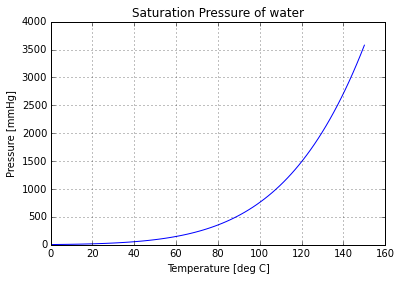

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def PsatPlot(species):
    for Tmin,Tmax in adb.ix[species].index:
        T = np.linspace(Tmin,Tmax)
        plt.plot(T,Psat(species,T),'b')
    plt.xlabel('Temperature [deg C]')
    plt.ylabel('Pressure [mmHg]')
    plt.title('Saturation Pressure of ' + species)
    plt.grid();
    
PsatPlot('water')

### Interactive Widget for Plotting Saturation Pressure

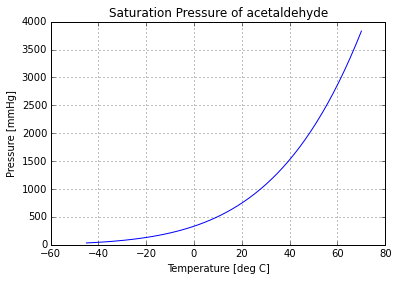

In [8]:
import ipywidgets as widgets
from IPython.display import display

widgets.interact(PsatPlot, species=list(adb.index.levels[0]));

## Calculating Saturation Temperature

In [9]:
from scipy.optimize import brentq

def Tsat(species,P):
    if isinstance(P,np.ndarray):
        return [Tsat(species,p) for p in P]
    Ta = 1000.0
    Tb = -273.15
    for Tmin,Tmax in adb.ix[species.lower()].index:
        Ta = min(Ta,Tmin)
        Tb = max(Tb,Tmax)
    try:
        return brentq(lambda T: Psat(species,T) - P,Ta,Tb)
    except:
        return float('nan')

#### Create a Table of Normal Boiling Points

The normal boiling point of a liquid is the temperature at which the vapor pressure is equal to one atmosphere.

In [10]:
P = 760.0
species = list(adb.index.levels[0])

print "Normal Boiling Points in Deg C."
for s in species:
    print '{0:15s}'.format(s),
    print '{0:6.1f}'.format(Tsat(s,P))

Normal Boiling Points in Deg C.
acetaldehyde      20.4
acetic acid      117.9
acetone           56.2
benzene           80.1
ethanol           78.3
isopentane        27.9
methanol          64.7
n-heptane         98.4
n-hexane          68.7
n-pentane         35.1
toluene          111.6
water            100.0


## Specific Humidity

For a given mass of moist air $m_{air}$, specific humidity is the ratio of the mass of water vapor $m_w$ to the mass of dry air $m_{dry\ air}$. 

$$SH = \frac{m_w}{m_{dry\ air}}$$

From Dalton's law, the mole fraction of a species in an ideal gas is proportional to it's partial pressure. $M_{w} = 18.01$ is the molar mass of water, and $M_{air} = 28.97$ is the molar mass of air. This gives

$$SH = \frac{M_w P_w}{M_{air} (P_T - P_w)}$$

where $P_w$ is the partial pressure of water in the moist air, and $P_T$ is total moist air pressure. The maximum specific humidity occurs when $P_w = P^{sat}_w(T)$ which gives us a simple formula

$$SH_{max} = \frac{M_w}{M_{air}} \frac{P^{sat}_w(T)}{(P_T - P^{sat}_w(T))}$$

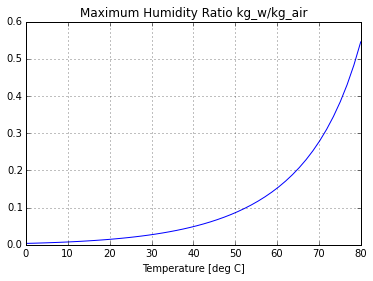

In [11]:
T = np.linspace(0.0,80.0)
Mw = 18.01
Ma = 28.97
P = 760.0

def SH(T):
    return Mw*Psat('water',T)/(Ma*(P-Psat('water',T)))

plt.plot(T, map(SH,T))
plt.title('Maximum Humidity Ratio kg_w/kg_air')
plt.xlabel('Temperature [deg C]')
plt.grid()

## Exercises
Use the data and functions demonstrated above to solve the answer the following questions. 

#### Problem 1.
A clothes dryer has a medium temperature setting of 135 degrees F and a high temperature setting of 150 degrees F.  A load of clothes takes 45 minutes to dry on the high setting with an inlet temperature of 70 degrees F. Assuming the inlet and outlet air streams are saturated with water vapor, how long will it take to dry clothes on the medium temperature setting?

#### Problem 2.
An empty 5000 gallon reactor is initially purged with dry nitrogen gas at one atmosphere pressure. The reactor is then slowly filled with pure hexane at 25 degrees C. Assuming the partial pressure of hexane is at the saturation pressure of hexane, how much hexane vapor is released in the process of filling the tank?

In [12]:
# Volume of the tank in liters
V = 5000.0*3.785

# Gas constant in liter-atm/K gmol
R = 0.08205

# Partial pressure of hexane in atm
P = Psat('n-hexane',25)/760.0
print P

n = P*V/(R*(25.0+273.15))
print n


0.199266553529
154.154745469


#### Problem 3.

Ethanol is blended into gasoline feedstocks at 10 vol%.  (That is, 1 liter of ethanol is blended with 9 liters of gasoline feedstock). Assume gasoline feedstock has the same chemical properties as n-heptane ($C_7H_{16}$). 

* What is the mole fraction of ethanol in the blended mixture?
* On a hot day the temperature in the fuel tank can reach 40 degC. Assuming a vapor-liquid equilibrium is established, what is the composition (nitrogen, oxygen, ethanol, and heptane) of the vapor in the fuel tank?
* Calculate the temperature and vapor composition at the bubble point of this blend.                    

In [13]:
rho = {}
rho['ethanol'] = 0.789
rho['n-heptane'] = 0.684

MW = {}
MW['ethanol'] = 46.01
MW['n-heptane'] = 100.2

nE = rho['ethanol']*1.0/MW['ethanol']
nH = rho['n-heptane']*9.0/MW['n-heptane']

xE = nE/(nE + nH)
xH = nH/(nE + nH)

print
print "Mole fraction ethanol (gasoline blend) = ", xE
print "Mole fraction n-heptane (gasoline blend) = ", xH

T = 40.0
P = 760.0

yE = xE*Psat('ethanol',T)/P
yH = xH*Psat('n-heptane',T)/P

print
print "Mole fraction ethanol (vapor) = ", yE
print "Mole fraction n-heptane (vapor) = ", yH

yN = (1-yE-yH)/(1 + 0.21/0.79)
yO = (0.21/0.79)*yN

print "Mole fraction nitrogen = ", yN
print "Mole fraction oxygen = ", yO



Mole fraction ethanol (gasoline blend) =  0.218213669642
Mole fraction n-heptane (gasoline blend) =  0.781786330358

Mole fraction ethanol (vapor) =  0.0384810648393
Mole fraction n-heptane (vapor) =  0.0951545087371
Mole fraction nitrogen =  0.684427896875
Mole fraction oxygen =  0.181936529549
